In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt 
import os

In [2]:
#Set the current working directory / or manually type-in
cwdir = os.getcwd() #'/Users/jane_hsieh/Library/CloudStorage/OneDrive-國立陽明交通大學/Data Science 
os.chdir(cwdir)
print(cwdir)

#indicate the directory path for the fold where 4 MNIST data are located (default: in cwdir)
data_dir = './MNIST Database'

/work/files/workspace


# 0. Input Data: MNIST

In [3]:
#1.1 Input training/testing data and their labels (X, y)
from mlxtend.data import loadlocal_mnist #make sure installed via conda
Train_X, Train_y = loadlocal_mnist(
        images_path=data_dir+'/train-images-idx3-ubyte', 
        labels_path=data_dir+'/train-labels-idx1-ubyte')

Test_X, Test_y = loadlocal_mnist(
        images_path=data_dir+'/t10k-images-idx3-ubyte', 
        labels_path=data_dir+'/t10k-labels-idx1-ubyte')

## Transform into DataFrame form
Train_X = pd.DataFrame(Train_X); print(f"shape of Train_X: {Train_X.shape}")
Train_y = pd.DataFrame(Train_y, columns = ["digit"]); print(f'shape of Train_y: {Train_y.shape}')
#Test_X = pd.DataFrame(Test_X)
#Test_y = pd.DataFrame(Test_y, columns = ["digit"])

'''
## Inspenct the frequency of each class (digit 0-9)
unique_elements, counts_elements = np.unique(Train_y, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))


Train_N = Train_X.shape[0]
print("Percentage of each class of Train_y data: \n {}".format(np.asarray((unique_elements, counts_elements/Train_N))))
'''
p = Train_X.shape[1]
width = int(math.sqrt(p))
shape =  (width, width); print(f"i.e., size of image of Train_X: {shape}")

shape of Train_X: (60000, 784)
shape of Train_y: (60000, 1)
i.e., size of image of Train_X: (28, 28)


# 1. Experiments of Anomaly Detection

## 1.1 ANN modeling, prediction & Evaluation


In [4]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import regularizers
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

# Define ANN models
def ANN(k):
    # Start with a sequential model
    autoencoder = Sequential()

    # Add a dense layer (first layer) with input the original image pixels and neurons the encoded representation
    autoencoder.add(Dense(k, input_shape=(p, ), activation="relu")) #for tabular data X(shape=(N, n_cols)), input_shape=(n_cols, )

    # Add an output layer with as many neurons as the orginal image pixels
    autoencoder.add(Dense(p, activation = "sigmoid"))

    # Compile your model with adadelta
    autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae', 'accuracy'])
    autoencoder.summary()
    return autoencoder


def ANN2(k):
    # Start with a sequential model
    autoencoder = Sequential()

    # Add a dense layer (first layer) with input the original image pixels and neurons the encoded representation
    autoencoder.add(Dense(k, input_shape=(p, ), activation="relu", 
                          activity_regularizer = regularizers.l1(10e-5))) #for tabular data X(shape=(N, n_cols)), input_shape=(n_cols, )

    # Add an output layer with as many neurons as the orginal image pixels
    autoencoder.add(Dense(p, activation = "sigmoid"))

    # Compile your model with adadelta
    autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mae', 'accuracy'])
    autoencoder.summary()
    return autoencoder


2023-04-11 04:30:40.849677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-11 04:30:40.849703: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
# Prediction dichotomization
def predict_binary(AD_scores, threshold = 0.05):
    """
    dichotomize largest (threshold*100)% of AD_score as anomalies (pred_y = 1), the rest as normal data (pred_y=0)
    Input: 
        AD_scores: outlier scores, len = sample size N
    Output:
        pred_y: binary data whether each case(row) of X is anomaly or not
    """    
    N = len(AD_scores)    
    N_A = math.ceil(N * threshold)

    #calculate the suspicious_index and suspicious_score    
    temp =sorted(enumerate(AD_scores), key=operator.itemgetter(1), reverse=True) 
    #return list of ([implicit] index, value) from largest to lowest
    temp = pd.DataFrame(temp)  #2nd column of temp is the d values ranking from biggest to lowest;
    s_index = temp.iloc[:,0]  #1st of that is the corresponding indices(positions) of d
    
    pred_y = np.zeros(N)
    pred_y[ s_index[:N_A]] = 1
    return pred_y

# Evaluation
def FPrate(y, y_pred):
    N1 = y[y == 1].sum()
    N0 = len(y) - N1
    cm = confusion_matrix(y, y_pred)
    return  cm[0, 1]/N0

def Classification_metrics(y, AD_binary):
    """
    Input: 
        y: true y (binary: 0, 1)
        AD_binary: pred_y, binary data whether each case(row) of X is anomaly or not
    Output: Binary classification metric, cm, TN, acc, f1, precision, recall     
    """
    cm = confusion_matrix(y, AD_binary);print("confusion_matrix:\n{}".format(cm))
    acc = accuracy_score(y, AD_binary);print("accuarcy: {}".format(acc))
    TN = 1- FPrate(y, AD_binary).values[0];print("TN rate: {}".format(TN))        
    recall = recall_score(y, AD_binary);print("recall score: {}".format(recall))
    f1 = f1_score(y, AD_binary);print("f1 score: {}".format(f1))
    precision = precision_score(y, AD_binary);print("precision score: {}".format(precision))
    dic = {"cm": cm, "accuracy": acc, "TNrate": TN, "f1": f1, "precision": precision, "recall": recall}
    return dic

## 1.2 Experiments

In [6]:
import time
import operator
import random
random.seed(a=0) #fix a to a specific number, so the experiment can be replicated <--------------

### Parameter settings - customized
- Define normal & abnormal digit 
- Sample size (default: 95% normal data vs 5% abnormal data)

In [7]:
## Define normal diget: d_normal
d_normal = 0  #<----------------------------------------- you can define a number as normal
N0 = 5700
Train_X_0 = Train_X[Train_y.values == d_normal]

## Define abnormal digit: d_ab (1~9)
d_ab = 1      #<----------------------------------------- you can define a number as anomalies other than d_normal
N_ab = 300
Train_X_ab = Train_X[Train_y.values == d_ab]

N = N0 + N_ab

# For experiment design and anomaly detection classification
m = 1; print("{m}-st model selected") # 1 or 2
n_iter = 1 #{iterations}
ks = [3]
#ks = list(range(1,11))  #{hiddedn units}
batch_size = 60
epochs = 30
threshold = 0.05

{m}-st model selected


In [8]:
##Set the output folder name (fold should be put subordinate to cwdir)
out_folder = f'Out_{d_normal}vs{d_ab}'
out_dir = os.path.join(cwdir,out_folder)
if not os.path.exists(out_dir):
    os.mkdir(out_dir)
    
# output location
outF_E = open(os.path.join(out_dir, f"Evaluation_Error_{d_normal}vs{d_ab}.csv"), "a", newline='\n')
outF_D = open(os.path.join(out_dir, f"Evaluation_Distance_{d_normal}vs{d_ab}.csv"), "a", newline='\n')

iteration 0,	 k=3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 2355      
                                                                 
 dense_1 (Dense)             (None, 784)               3136      
                                                                 
Total params: 5,491
Trainable params: 5,491
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 3)                 2355      
                                                                 
 dense_3 (Dense)             (None, 784)               3136      
                                                                 
Total params: 

2023-04-11 04:30:42.492727: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-11 04:30:42.492754: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-11 04:30:42.492773: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (80ec5ba3-82a7-4f47-bda5-3ab506997493): /proc/driver/nvidia/version does not exist
2023-04-11 04:30:42.492978: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
100/100 [==============================] - 1s 1ms/step - loss: 0.1556 - mae: 0.3593 - accuracy: 6.6667e-04
Epoch 2/30
100/100 [==============================] - 0s 1ms/step - loss: 0.0623 - mae: 0.1592 - accuracy: 6.6667e-04
Epoch 3/30
100/100 [==============================] - 0s 1ms/step - loss: 0.0547 - mae: 0.1341 - accuracy: 8.3333e-04
Epoch 4/30
100/100 [==============================] - 0s 1ms/step - loss: 0.0528 - mae: 0.1276 - accuracy: 0.0015
Epoch 5/30
100/100 [==============================] - 0s 1ms/step - loss: 0.0502 - mae: 0.1231 - accuracy: 0.0028
Epoch 6/30
100/100 [==============================] - 0s 1ms/step - loss: 0.0472 - mae: 0.1175 - accuracy: 0.0040
Epoch 7/30
100/100 [==============================] - 0s 1ms/step - loss: 0.0453 - mae: 0.1128 - accuracy: 0.0048
Epoch 8/30
100/100 [==============================] - 0s 1ms/step - loss: 0.0443 - mae: 0.1101 - accuracy: 0.0050
Epoch 9/30
100/100 [==============================] - 0s 1ms/step - loss: 0.

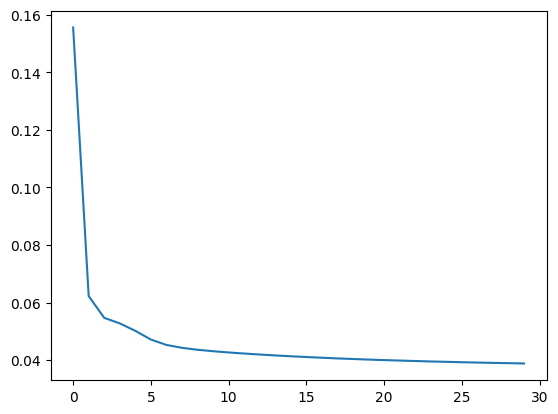

In [9]:
for it in range(n_iter):
    #1. Random sample data (X, y)++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
    ## Random select normal data with sample size = N0
    indices_select = random.sample( list(range(0,Train_X_0.shape[0])),  N0 ) 
    Train_X_0_sel = Train_X_0.iloc[indices_select].copy()  
    Train_y_0 = pd.DataFrame(np.zeros(N0), columns=['Is_Ab'])#Train_y[Train_y.values == d_normal][:N0] 
    Train_y_0.index = Train_X_0_sel.index
    
    ## Random select abnormal data with sample size = N0 + N_ab
    indices_select = random.sample( list(range(0,Train_X_ab.shape[0])),  N_ab ) 
    Train_X_ab_sel = Train_X_ab.iloc[indices_select]
    Train_y_ab = pd.DataFrame(np.ones(N_ab), columns=['Is_Ab'])#Train_y[Train_y.values == d_ab][:N_ab ] 
    Train_y_ab.index = Train_X_ab_sel.index
    
    ## Selected data for analysis
    X = Train_X_0_sel.append(Train_X_ab_sel) # N = 5700 + 300 = 6000
    y = Train_y_0.append(Train_y_ab)
    ### shuffle rows of (X, y)
    id_shuffle = X.index.tolist()
    random.shuffle(id_shuffle)#;print(id_shuffle[:10])
    #print(id_shuffle[0])
    id_shuffle = pd.Index(id_shuffle)    
    X = X.loc[id_shuffle, :]
    ### Feature Scaling
    X = X/255
    y = y.loc[id_shuffle]
    
    unique_elements, counts_elements = np.unique(y, return_counts=True)
    #print("Frequency of unique values of the said array:")
    #print( np.asarray((unique_elements, counts_elements)) )
    del Train_X_0_sel, Train_X_ab_sel, Train_y_0, Train_y_ab, indices_select    

    
    for k in ks:
        print(f'iteration {it},\t k={k}')
        start = time.time() #<<<!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        
        #2. Dimension Reduction & reconstruction: Autoencoder++++++++++++++++++++++++++++++++++++
        #2.2. Autoencoder modeling and fitting
        models = {"1": ANN(k), "2": ANN2(k)}
        autoencoder = models[str(m)] #ANN(k) or ANN2(k)
        model_history = autoencoder.fit(X, X, 
                                        batch_size = batch_size,epochs = epochs, 
                                        verbose = 1, shuffle = True)
        # training history monitoring
        train_history = pd.DataFrame(model_history.history)
        train_history['epoch'] = list(range(epochs))
        train_history.loss.plot()
        
        # Fitting results 
        ## reconstructed X - shape = (N, p)
        X_pred = autoencoder.predict(X) 

        ## Encoder (first half of Autoencoder)
        encoder = Sequential() # Build your encoder by using the first layer of your autoencoder
        encoder.add(autoencoder.layers[0]) #build structure of 1st layer (input->first hidden layer) onto raw model
        encodings = encoder.predict(X) # Encode the images 
        encodings_m = encodings.mean(axis=0) #mean of all encodings
        #print(encodings_m.shape)
        
        ## Efficiency
        end1 = time.time()
        t_it1 = end1 - start
        
        #3. For Anomaly Scores Calculation - Reconstruction Error ++++++++++++++++++++++++++++++ 
        for l in range(1,3):
            end1 = time.time()
            print(f"Reconstruction Error - L{l}")
            #3.1 Reconstruction Error - L1 vs L2
            AD_scores = np.linalg.norm(X - X_pred, ord=l, axis=1) #default: ord=None (2-norm)
            #print(len(AD_scores))
            #plt.boxplot(AD_scores)

            ##Dichotomize scores into {normal(0), abnormal(1)} with simple threshold
            AD_binary = predict_binary(AD_scores, threshold = threshold)
            AD_binary = pd.Series(AD_binary, index = X.index)        
        
            # 3.2 Ad-hoc Evaluations 
            ## Efficacy
            metrics = Classification_metrics(y, AD_binary)
            ## Efficiency
            end2 = time.time()
            t_it2 = end2 - end1 #unit: sec.
            
            #3.3 Output
            record = pd.DataFrame([{"ANN_model": m, "digit_Ab": d_ab, 
                                    "iteration": it, "k": k, "L": l,
                                    "accuracy": metrics["accuracy"],
                                    "TNrate": metrics["TNrate"], 
                                    "recall": metrics["recall"],
                                    "f1": metrics["f1"], 
                                    "precision": metrics["precision"], "time": t_it1 + t_it2,
                                    "metric": 'Construction Error'
                                }])                 
            #print(outF_E.tell())
            #record.to_csv(outF_E,mode='a',header = outF_E.tell()==0, index=False)
            del metrics, record, AD_scores, AD_binary
            
        del l, X_pred
              
        
        #4. For Anomaly Scores Calculation - Centered Distance in Projection space ++++++++++
        for l in range(1,3):
            end1 = time.time()
            print(f"Centered Distance in Projection space - L{l}")            
            #4.1 Centered Distance in Projection/representation space  - L1 vs L2
            AD_scores = np.linalg.norm(encodings - encodings_m, ord=l, axis=1)
            #print(len(AD_scores))
            #plt.boxplot(AD_scores)

            ##Dichotomize scores into {normal(0), abnormal(1)} with simple threshold
            AD_binary = predict_binary(AD_scores, threshold = threshold)
            AD_binary = pd.Series(AD_binary, index = X.index)        

            # 4.2 Ad-hoc Evaluations 
            ## Efficacy
            metrics = Classification_metrics(y, AD_binary)
            ## Efficiency
            end2 = time.time()
            t_it2 = end2 - end1 #unit: sec.            
            #4.3 Output
            record = pd.DataFrame([{"ANN_model": m, "digit_Ab": d_ab, 
                                    "iteration": it, "k": k, "L": l,
                                    "accuracy": metrics["accuracy"],
                                    "TNrate": metrics["TNrate"], 
                                    "recall": metrics["recall"],
                                    "f1": metrics["f1"], 
                                    "precision": metrics["precision"], "time": t_it1 + t_it2,
                                    "metric": 'Projection Distance'
                                }])                 
            #print(outF_D.tell())
            #record.to_csv(outF_D,mode='a',header = outF_D.tell()==0, index=False)
            del metrics, record, AD_scores, AD_binary
            
        del l, encodings, encodings_m, models #, autoencoder
        
    #del X, y 
    
outF_E.close()
outF_D.close()

# 3. Exploration

## 3.1 Normal Pattern Exploration

### Comparison of Original vs Reconstructed images  (2 normal + 2 abnormal cases)
- Uppler row: Original images
- Lower row: Reconstructed images

In [10]:
k = ks[0]

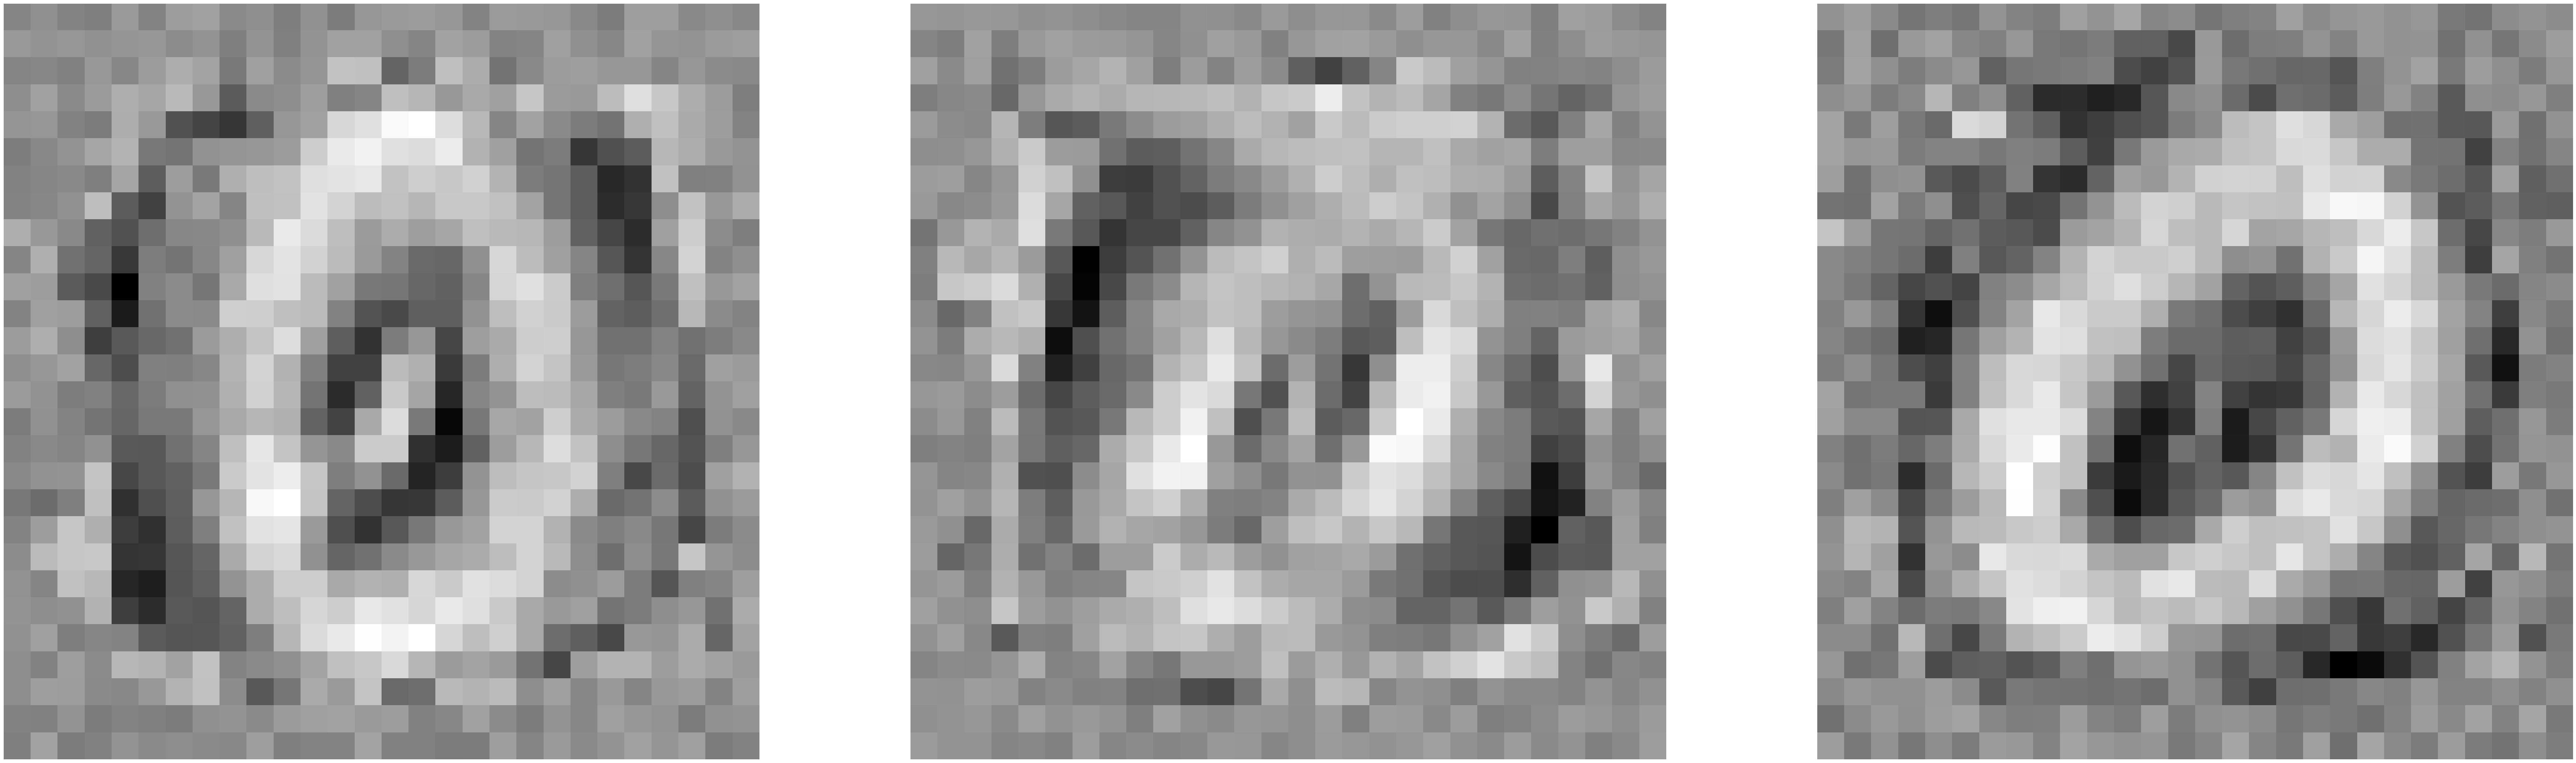

In [11]:
fig = plt.figure(figsize=(90, 30))
for i in range(k):
    img_c = autoencoder.layers[0].get_weights()[0][:,i].reshape(shape)
    fig.add_subplot(1, 3, i+1)
    plt.imshow(img_c, cmap='gray')
    plt.axis('off')
     
plt.savefig( os.path.join(out_dir, f"Features_ANN{m}_k{k}_{d_normal}vs{d_ab}.png"))    
plt.show()

### Normal patterns with $k$-hidden units
- derived from estimated weights of the first layer

In [12]:
#i = np.random.choice(ab_ids, 2, replace=False);i
ids_ab = np.where(y == 1)[0] #indices of anomalies
ids_normal = list(set(np.arange(6000)) - set(ids_ab))

ids_s = np.random.choice(ids_normal, 2, replace=False).tolist() + np.random.choice(ids_ab, 2, replace=False).tolist()
print(ids_s)

#ids_s = [3393, 4113, 5153, 5083]

[5234, 4827, 5004, 4624]


1/1 [==============================] - 0s 11ms/step


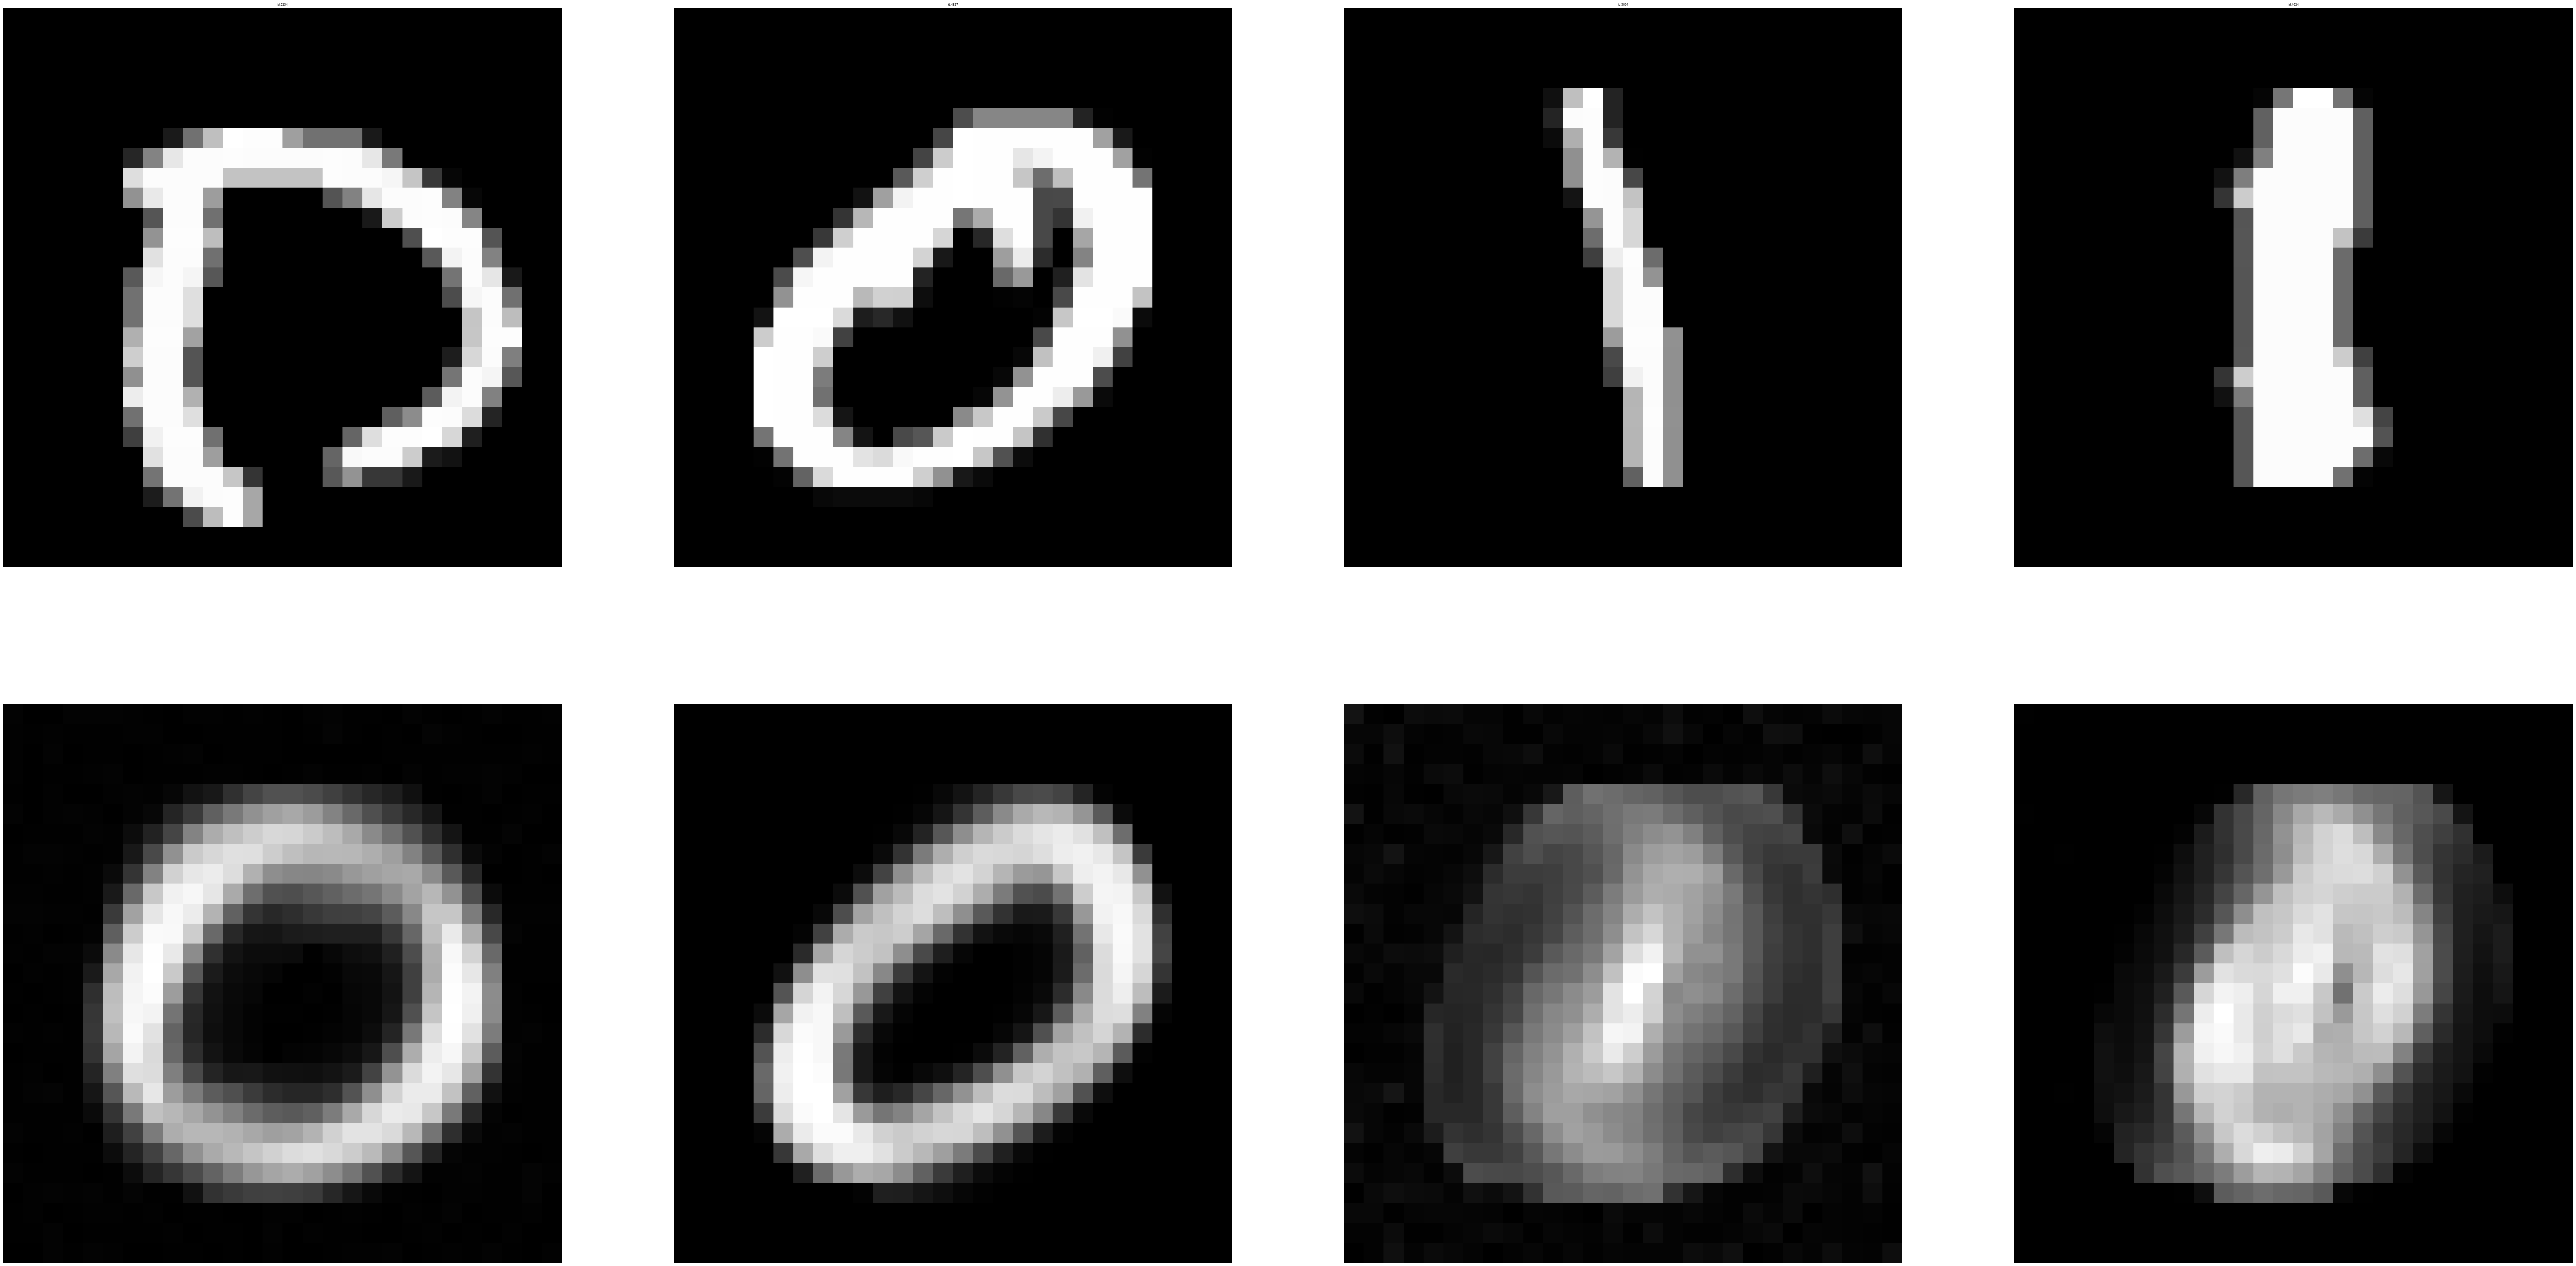

In [13]:
j = 1
fig = plt.figure(figsize=(100, 50))
for i in ids_s:
    img_c = X.values[i,:].reshape(shape)
    fig.add_subplot(2, 4, j)
    plt.imshow(img_c, cmap='gray')
    plt.title("id:{}".format(i), fontsize=6)   
    plt.axis('off')
     
    img_c = autoencoder.predict(X.values[i,:].reshape((-1,p))).reshape(shape)
    fig.add_subplot(2, 4, j+4)
    plt.imshow(img_c, cmap='gray')
    #plt.title("id:{}".format(i), fontsize=6)   
    plt.axis('off')  
    j+=1

plt.savefig( os.path.join(out_dir, f"Comparison-original_vs_constructed images_ANN{m}_k{k}_{d_normal}vs{d_ab}.png"))    
plt.show()

# 4. Data Representation
## 4.1 Encoder Results: Lower Space Representation

188/188 [==============================] - 0s 601us/step
confusion_matrix:
[[5660   40]
 [  40  260]]
accuarcy: 0.9866666666666667
TN rate: 0.9929824561403509
recall score: 0.8666666666666667
f1 score: 0.8666666666666667
precision score: 0.8666666666666667


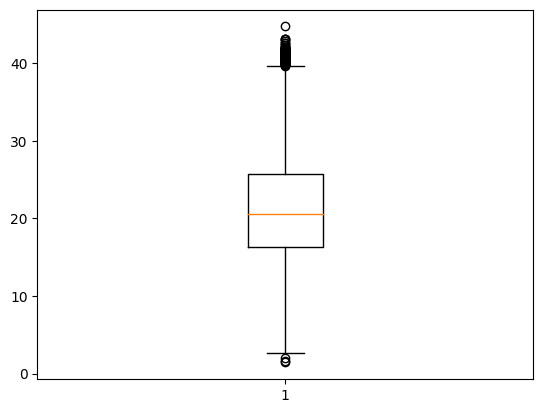

In [14]:
## Encoder (first half of Autoencoder)
encoder = Sequential() # Build your encoder by using the first layer of your autoencoder
encoder.add(autoencoder.layers[0]) #build structure of 1st layer (input->first hidden layer) onto raw model
encodings = encoder.predict(X) # Encode the images 
encodings_m = encodings.mean(axis=0) #mean of all encodings

AD_scores = np.linalg.norm(encodings - encodings_m, ord=1, axis=1)
#print(len(AD_scores))
plt.boxplot(AD_scores)

##Dichotomize scores into {normal(0), abnormal(1)} with simple threshold
AD_binary = predict_binary(AD_scores, threshold = threshold)
AD_binary = pd.Series(AD_binary, index = X.index) 

metrics = Classification_metrics(y, AD_binary)

### 3D scatterplot from Encoder

In [15]:
from plotly.offline import plot # to make plotly work in spyder, add this line and replace "fig.show()" with plot(fig)
import plotly.express as px
import plotly.graph_objs as go

#AD_binary: predicted abnormal classes: 0: normal, 1: abnormal
AD_symbol = AD_binary.map({0: 'circle', 1: 'x'}) #[‘circle’, ‘square’, ‘x’]

axis_x = 'W1'
axis_y = 'W2'
axis_z = 'W3'

layout = go.Layout(title_text="Encoder Projection (Blue: true normal, Red: true anomaly, Cross: pred. anomaly)",
                       scene=dict(xaxis_title=axis_x, yaxis_title= axis_y, zaxis_title=axis_z))
fig = go.Figure(data=[go.Scatter3d(x = encodings[:,0], y = encodings[:,1], z=encodings[:,2], 
                                   mode='markers',
                                   marker=dict(size=2, color=y['Is_Ab'], 
                                               colorscale=[(0,'blue'), (1, 'red')], opacity=0.5, 
                                               symbol = AD_symbol 
                                               )
                                  ) ], layout=layout)
fig.show()   
#plot(fig)
fig.write_html( os.path.join(out_dir, f"3D Scatter plot after Encoder_k{k}.html") )

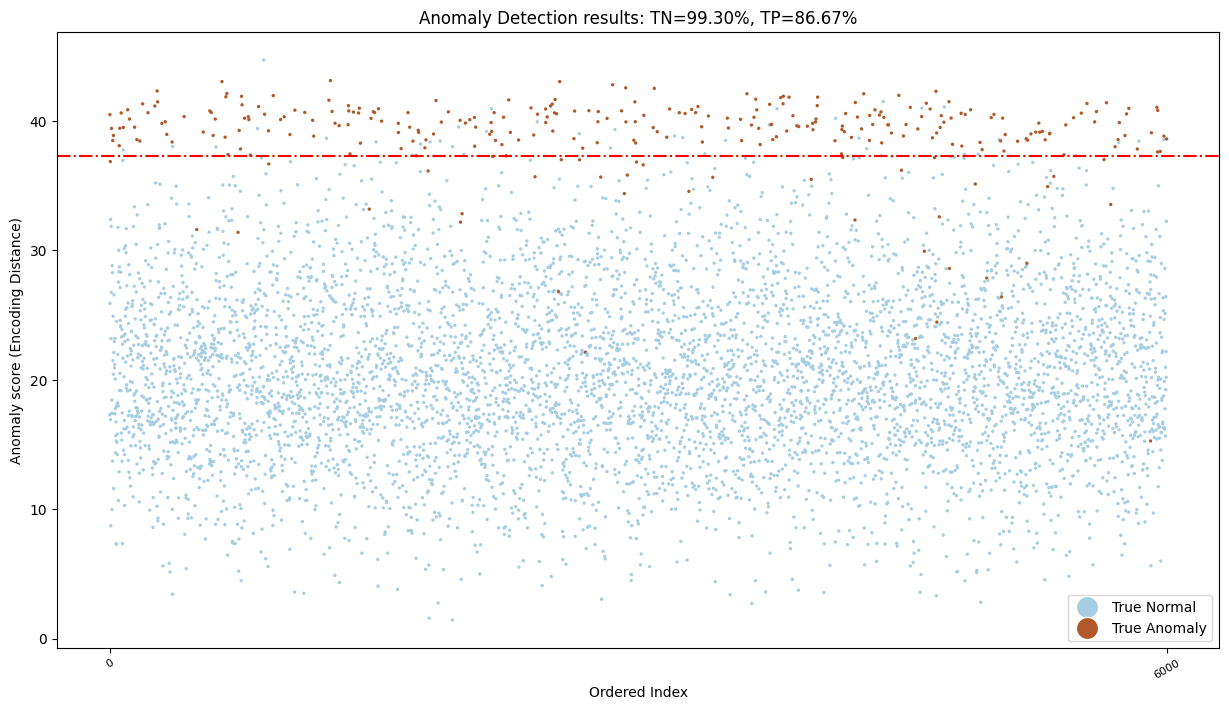

<Figure size 640x480 with 0 Axes>

In [16]:
## Visualization of 'AD_scores' for each case(Normal/Anomlay) 
import matplotlib as mpl

AD_score_min = AD_scores[AD_binary==1].min()


c_hex = []
c_rgb = []
cmap = mpl.cm.get_cmap('Paired', 2) ## extract 2 discrete colors from "Paired" cmap

#Extract colors from pre-defined cmap and turn them in html hex code 
for i in range(2):  
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    c_rgb.append(rgb)
    c_hex.append(mpl.colors.rgb2hex(rgb))  #turn rgb in html hex code 

#Build customized legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='True Normal', 
                          markerfacecolor=c_hex[0], markersize=16),  
                   Line2D([0], [0], marker='o', color='w', label='True Anomaly', 
                          markerfacecolor=c_hex[1], markersize=16) 
                   ] #alternative of markerfacecolor =c_rgb[0] & c_rgb[1]

plt.figure(figsize=(15,8))
plt.scatter(x = range(X.shape[0]), y=AD_scores, s = 2, c = y['Is_Ab'], cmap=cmap)
plt.xticks(range(0, X.shape[0]+1, 6000),size = 8, rotation = 30)
plt.axhline(AD_score_min, linestyle='-.', color='red')
plt.xlabel('Ordered Index')
plt.ylabel('Anomaly score (Encoding Distance)')
plt.title(f'Anomaly Detection results: TN={metrics["TNrate"]*100:.2f}%, TP={metrics["recall"]*100:.2f}%')
plt.legend(handles=legend_elements, loc='lower right')
plt.show()
plt.savefig(os.path.join(out_dir, "AD results-Encoding Distance (L1).jpg"))

#plt.close()

## 4.2 Decoder Results: AD Scores from Reconstructed Data


188/188 [==============================] - 0s 670us/step
confusion_matrix:
[[5432  268]
 [ 268   32]]
accuarcy: 0.9106666666666666
TN rate: 0.9529824561403508
recall score: 0.10666666666666667
f1 score: 0.10666666666666669
precision score: 0.10666666666666667


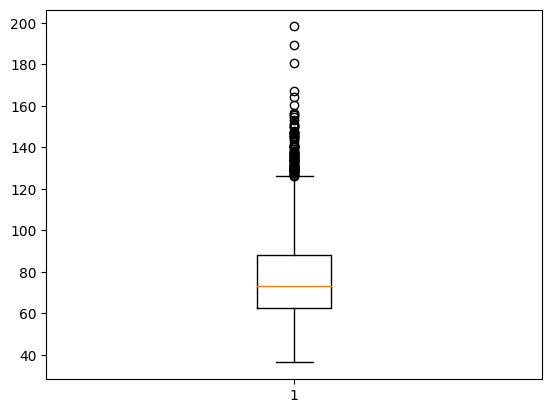

In [17]:
X_pred = autoencoder.predict(X)

#3.1 Reconstruction Error - L1 
AD_scores = np.linalg.norm(X - X_pred, ord=1, axis=1) #default: ord=None (2-norm)
#print(len(AD_scores))
plt.boxplot(AD_scores)

##Dichotomize scores into {normal(0), abnormal(1)} with simple threshold
AD_binary = predict_binary(AD_scores, threshold = threshold)
AD_binary = pd.Series(AD_binary, index = X.index)

metrics = Classification_metrics(y, AD_binary)

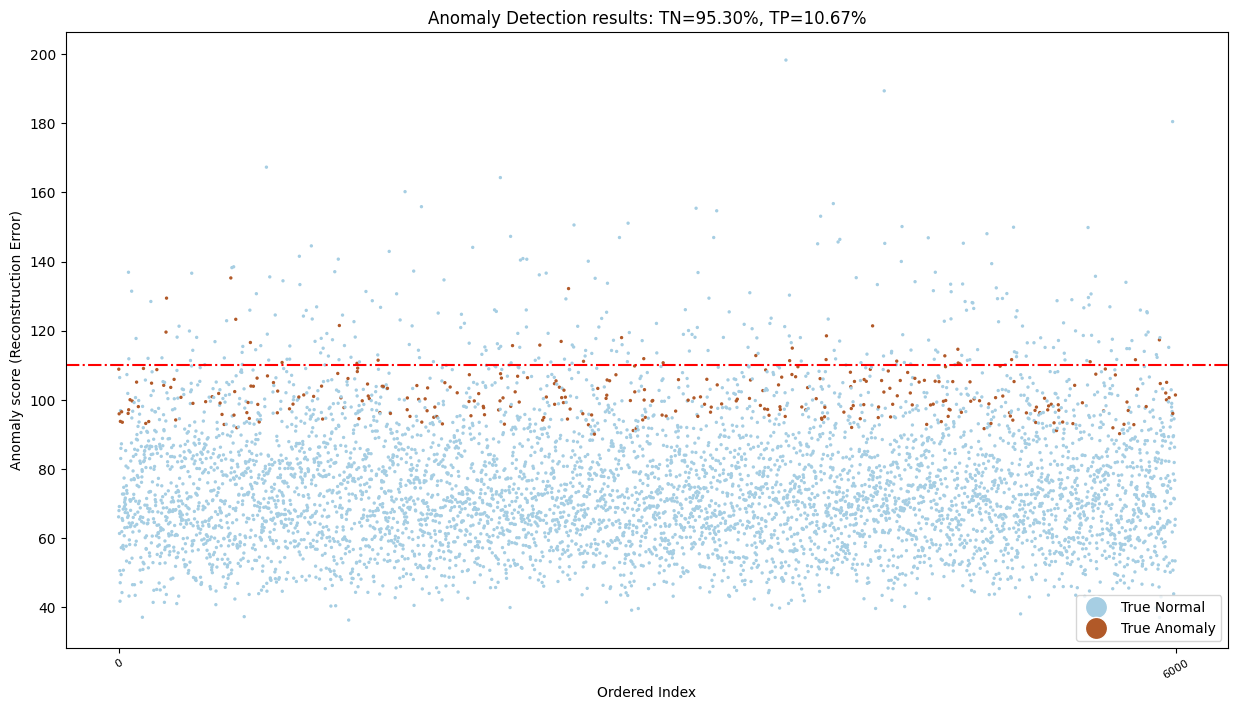

<Figure size 640x480 with 0 Axes>

In [18]:
## Visualization of 'AD_scores' for each case(Normal/Anomlay) 
#import matplotlib as mpl

AD_score_min = AD_scores[AD_binary==1].min()


c_hex = []
c_rgb = []
cmap = mpl.cm.get_cmap('Paired', 2) ## extract 2 discrete colors from "Paired" cmap

#Extract colors from pre-defined cmap and turn them in html hex code 
for i in range(2):  
    rgb = cmap(i)[:3] # will return rgba, we take only first 3 so we get rgb
    c_rgb.append(rgb)
    c_hex.append(mpl.colors.rgb2hex(rgb))  #turn rgb in html hex code 

#Build customized legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='True Normal', 
                          markerfacecolor=c_hex[0], markersize=16),  
                   Line2D([0], [0], marker='o', color='w', label='True Anomaly', 
                          markerfacecolor=c_hex[1], markersize=16) 
                   ] #alternative of markerfacecolor =c_rgb[0] & c_rgb[1]

plt.figure(figsize=(15,8))
plt.scatter(x = range(X.shape[0]), y=AD_scores, s = 2, c = y['Is_Ab'], cmap=cmap)
plt.xticks(range(0, X.shape[0]+1, 6000),size = 8, rotation = 30)
plt.axhline(AD_score_min, linestyle='-.', color='red')
plt.xlabel('Ordered Index')
plt.ylabel('Anomaly score (Reconstruction Error)')
plt.title(f'Anomaly Detection results: TN={metrics["TNrate"]*100:.2f}%, TP={metrics["recall"]*100:.2f}%')
plt.legend(handles=legend_elements, loc='lower right')
plt.show()
plt.savefig(os.path.join(out_dir, "AD results-Reconstruction Error (L1).jpg"))
#plt.close()